FINAL PROJECT DATA SCIENCE BATCH 007 GROUP 3

GROUP NAME : BULLETIN - CYBERBULLYING DETECTOR

MEMBERS : ARI RISCAHYO NUGROHO, ARSY BILAHIL TAMA, RESTI KURNIA PUTRI

THEME : NLP TEXT CLASSIFICATION

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Introduction

This notebook contains Cyberbullying Tweet dataset from *J. Wang, K. Fu, C.T. Lu, “SOSNet: A Graph Convolutional Network Approach to Fine-Grained Cyberbullying Detection,” Proceedings of the 2020 IEEE International Conference on Big Data (IEEE BigData 2020), December 10-13, 2020*, available on https://www.kaggle.com/andrewmvd/cyberbullying-classification 

***TRIGGER WARNING!*** This notebook contains **offensive words regarding to age, gender, religion, ethnicity.** There might also be words containing **sexual harrassment.**

***PROCEED AT YOUR OWN RISK*** 

Before we continue, here are some notes regarding the dataset:

The author of the paper **used semi-supervised learning to generate and label some of the data in this dataset.** The goal for the paper is to **combat imbalanced dataset problems** occurring in NLP research. As such, **you might find incorrectly labeled data even in the original dataset**

**Humans' judgment are not bias-free. AI was built using input from humans' data.** **AI has limited capability**

Any seemingly incorrect labeled data could be caused from the AI failure to classify, creators' bias, readers' bias, or all of them. 


## Import Library

In [2]:
#!pip install langdetect

In [3]:
#!pip install tensorflow

In [4]:
# Import libraries untuk mendukung jalannya analisa.

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
import plotly.graph_objects as go
import re

import nltk
from nltk.tokenize.casual import TweetTokenizer
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Dropout, TextVectorization
from tensorflow.keras.models import Sequential

import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Download Required NLTK Package

In [5]:
# Download NLTK untuk mendukung jalannya analisa.

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

## Data Load and EDA

In [6]:
# Menampilkan kolom maksimum.

pd.set_option('display.max_colwidth', None)

In [7]:
# Upload dataset Cyberbullying Classification dengan bantuan pandas.

df = pd.read_csv("https://raw.githubusercontent.com/Ari2109/data_repo/main/cyberbullying_tweets_2.csv")

In [8]:
# Menampilkan 10 baris dari data secara acak.

df.sample(10)

,tweet_text,cyberbullying_type
9898,RT @Vulc4nMind @Aandapples // nope. I'm not sexist but I think the doctor should stick with a male,gender
34332,"So many people I went to school with act like they grew up not being the bullies.. At least I?╟╓m running my own company, working a full time job, and raising my son all with 1 year of college. And I?╟╓m debt free. Damn.",age
10239,I will stop tweeting this when it stops being necessary: 1. rape jokes are never funny 2. retarded &amp; gay are not words to be used as insults,gender
42634,This nigga Reub has some of the worst communication skills ???â?±?¬???â?┼???≤?╟?∞?≤?╓?Θ?╗???┼,ethnicity
17204,"Well @ChickfilA the SPLC is a far leftist organization anti-Christian PAC, labeling all groups that don't support their radical hare groups. Might as well donate to Planned Parenthood and GLAAD.",religion
20625,"@OdiniaInvictus @SirajZarook @BilalIGhumman @IsraeliRegime Judaism doesn't want to take over the world, like Islam.",religion
45145,Of color is the correct term. Colored refers to segration. I do know several cops who identify as POC and they speak on the racism in the Boston departments but treat it like a regular job and never speak on this ?╟úchange?╟Ñ u insist they?╟╓re infiltrating from behind enemy lines,ethnicity
3304,#mkr 3 the girls are gonna be pissed about that,not_cyberbullying
17388,I'm going to vent here... I am not an over the top religious preachy person( But Be asure..I'm a Born again Christian Woman). I believe we all have the right to worship as we please. I believe we should be proud of... https://www.facebook.com/751349264/posts/10157626494029265/,religion
37891,These celebrities are like those bullies in school that would taunt two kids to fight each other while they sat back and enjoyed the power they had over them.,age


We'll check the what are the classes provided in this dataset.

In [9]:
# Menampilkan klasifikasi cyberbullying

df['cyberbullying_type'].unique()

# Terlihat bahwa terdapat 6 kelas dari kolom cyberbullying_type, yaitu non-cyberbullying, age, gender, ethnicity, religion, other-cyberbullying.

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

We'll check if there's any null data in the dataset.

In [10]:
# Memeriksa jika terdapat missing values dari dataset.

df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

Seems like there isn't missing values. Let's go to do some data cleaning.

## Data Cleaning

We'll do with one sample text to make clear of what did we do to clean

### Sample Text Cleaning

In [11]:
# Menampilkan baris ketiga dari kolom tweet_text sebagai contoh.

sample_text = df.loc[3]['tweet_text']
print(sample_text)

@Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.


As this is twitter, we'll remove the @username. But we'll try to preserve the emoji/emoticon

In [12]:
# Menghapus @'username' dan punctuation, tetapi tetap mempertahankan emoji / emoticon.

sample_text = re.sub('@[^\s]+','',sample_text)
sample_text = re.sub('(?<=\w)[^\s\w](?![^\s\w])', '', sample_text)
print(sample_text)

# Terlihat bahwa contoh kalimat hanya tersisa emoji dan kata-katanya saja.

 meh :P  thanks for the heads up but not too concerned about another angry dude on twitter


We'll use TweetTokenizer to ensure that the emoticon stayed intact

In [13]:
# Word tokenizer, twitter style (memecah kalimat menjadi per kata dengan mempertahankan emoji menjadi kata tersendiri).

t = TweetTokenizer()
word_token = t.tokenize(sample_text)
print(word_token)

['meh', ':P', 'thanks', 'for', 'the', 'heads', 'up', 'but', 'not', 'too', 'concerned', 'about', 'another', 'angry', 'dude', 'on', 'twitter']


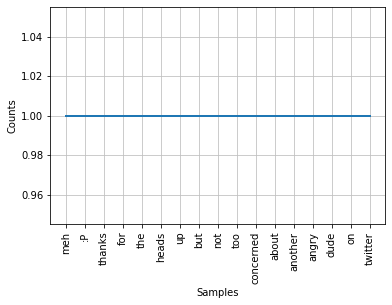

In [14]:
# Menampilkan perolehan kata dari contoh di atas.

fdist = FreqDist(word_token)
fdist.plot(30, cumulative=False)
plt.show()

# Terlihat bahwa tiap kata memiliki jumlah perolehan 1 kata (kebetulan contoh yang diambil hanya 1 kalimat saja).

Note that the author of the paper does *not* clean the stopword because the author believed that the stopwords might contain more pattern regarding to cyberbullying. As such, we also not do stopword-cleaning.

We'll try to do Stemming and Lemmatization-with-POS here. We'll only use one of them in the end later.

In [15]:
# Lexicon Normalization
# Melakukan Stemming untuk memecah kata menjadi kata dasar.

ps = PorterStemmer()

stemmed_words = []
for w in word_token:
    stemmed_words.append(ps.stem(w))

print("Filtered Sentence:", word_token)
print("Stemmed Sentence:", stemmed_words)

# Terlihat perbedaan hasil tweet tokenizer (Filtered Sentence) dan stemming (Stemmed Sentence).
# Filtered Sentence memiliki hasil yang serupa seperti bila dilakukan Lemmatization karena memecah kata berdasarkan kamus.
# Stemmed Sentence memiliki hasil yang serupa namun pasti akan ada beberapa kata yang memiliki arti yang tidak wajar.

Filtered Sentence: ['meh', ':P', 'thanks', 'for', 'the', 'heads', 'up', 'but', 'not', 'too', 'concerned', 'about', 'another', 'angry', 'dude', 'on', 'twitter']
Stemmed Sentence: ['meh', ':P', 'thank', 'for', 'the', 'head', 'up', 'but', 'not', 'too', 'concern', 'about', 'anoth', 'angri', 'dude', 'on', 'twitter']


In [16]:
# Melakukan Lemmatization with POS untuk mendapatkan kata dasar berdasarkan kamus.

lem = WordNetLemmatizer()
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    lem.lemmatize(word,)
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_pos(tokenized_text):
    lemmatized = []
    for word in tokenized_text:
      lemmatized.append(lem.lemmatize(word, pos=get_wordnet_pos(word)))
    return lemmatized

lemmatized_token = lemmatize_pos(word_token)

def join_lemmatize_sentence(lemmatized_token):
  lemmatized_sentence = ""
  for x in lemmatized_token:
    lemmatized_sentence = lemmatized_sentence + " " + x
  lemmatized_sentence = lemmatized_sentence.strip()
  return lemmatized_sentence

join_lemmatize_sentence(lemmatized_token)
#print("Lemmatized with POS:", [lem.lemmatize(w, pos=get_wordnet_pos(w)) for w in word_token])

'meh :P thanks for the head up but not too concerned about another angry dude on twitter'

The decision is to use the lemmatization with POS in hope to keep some context in the texts.

### Entire Dataset Cleaning

In [17]:
# Membuat salinan dataset yang diberi nama "df_prep" agar tidak memberikan perubahan pada dataset asli.

df_prep = df.copy()

In [18]:
# Membuat pipeline untuk menghilangkan tanda baca, huruf besar, dan istilah-istilah lain yang tidak memiliki arti kata.

class proces_case_folding(BaseEstimator, TransformerMixin):
    
    def __init__(self, create=True):
        self.create = create
        
    def fit(self, X, y=None):
        return self
    
    def process(self, X):
        text = X.lower()
        #remove (at)username
        text = re.sub('@[^\s]+','',text)
        #remove RT flag
        text = re.sub('rt[\s]', '', text)
        #remove http and https
        text = re.sub('http[^\s]+', '', text)
        #remove & (occured in &amp and stuff)
        text = re.sub('&[^\s]+', '', text)
        text = re.sub(f'\d','', text)
        text = text.translate(str.maketrans(" "," ", string.punctuation))
        text = text.strip()
        return text
    
# Mengaplikasikan pada kolom tweet_text di sebuah kolom baru yaitu Case Folding.

    def transform(self, X):
        X['Case Folding'] = X['tweet_text'].apply(self.process)
        return X['Case Folding']

In [19]:
# Membuat salinan dataset yang diberi nama "df_prep_e" agar tidak memberikan perubahan pada dataset df_prep.

df_prep_e = df_prep.copy()
df_prep_e.head(1)

# Menampilkan baris pertama dari hasil perubahan setelah dilakukan pembersihan sebelumnya.

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying


In [20]:
# Import zipfile
# Archive = zipfile.ZipFile("../input/language-filtering.zip", 'r')
# model_pkl = archive.read('model_filter_language.pkl')

import joblib
load_model = joblib.load("model_filter_language.pkl")

In [21]:
# Mengevaluasi model dari Language Detection kepada dataset df_prep_e untuk mendeteksi bahasa Inggris saja yang terdapat pada dataset Cyberbullying yang selanjutnya dilakukan analisa cyberbullying tweets dengan bahasa Inggris.
# Menampilkan hasilnya pada kolom baru language.

df_prep_e['language'] = load_model.predict(df_prep_e)

In [22]:
# Menampilkan klasifikasi dari hasil filtering bahasa Inggris.

df_prep_e['language'].unique()

array([ 3, 16, 11,  5,  8, 13,  2,  4,  1, 12,  6, 14])

In [23]:
# Membuang data yang isinya kosong setelah dilakukan preprocessing.

drop_index = df_prep_e[df_prep_e['Case Folding'] ==''].index
print(drop_index.shape)
print(df_prep_e.shape)

# Menampilkan ukuran dari hasil drop_index dibandingkan dengan data df_prep_e.

(277,)
(55637, 4)


In [24]:
# Menampilkan jumlah perolehan kolom tweet_text berdasarkan kolom language.

df_prep_e.groupby('language').count()['tweet_text']

language
1        24
2        35
3     54820
4        49
5         9
6         1
8        44
11      395
12        2
13      226
14       18
16       14
Name: tweet_text, dtype: int64

In [25]:
# Membuat array kolom language menjadi 3.

df_prep_e = df_prep_e[df_prep_e['language'] == 3]

In [26]:
# Menampilkan array kolom language.

df_prep_e['language'].unique()

# Array kolom language sudah menjadi 3

array([3])

In [27]:
# Menampilkan 5 baris secara acak dari data df_prep_e.

df_prep_e.sample(5)

# Terlihat bahwa klasifikasi language sudah menjadi 3.

,tweet_text,cyberbullying_type,Case Folding,language
48975,Icecream while I make @user u2019s birthday present for tomorrow! LOVE YOU LAURIN!!,not_cyberbullying,icecream while i make us birthday present for tomorrow love you laurin,3
42563,"@WassupWitcha go back then, niggers out here dumb as fuck for no reason.",ethnicity,go back then niggers out here dumb as fuck for no reason,3
26820,"RT @grexican: @YesYoureSexist Sorry, I won't use facts next time. I'll just go with the rest of the masses who think there are NO differenc?╟¬",other_cyberbullying,sorry i wont use facts next time ill just go with the rest of the masses who think there are no differenc╟¬,3
53989,"Miles just hit a 3, matched by Gerald Green...Indy is a deep team...good test for Cavs tonight...down 3 half way thru 2nd..Waiters returning",not_cyberbullying,miles just hit a matched by gerald greenindy is a deep teamgood test for cavs tonightdown half way thru ndwaiters returning,3
1553,Shabazz is the first time I've seen a college players profile pic w diamond studs! Looking like KG's picture..,not_cyberbullying,shabazz is the first time ive seen a college players profile pic w diamond studs looking like kgs picture,3


## Data Visualization

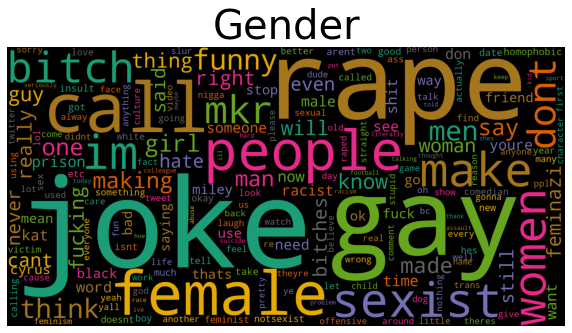

In [28]:
# Menampilkan visualisasi cyberbullying gender.

plt.figure(figsize=(10,8))
subset1 = df_prep_e[df_prep_e['cyberbullying_type']=='gender']
text_gender = subset1['Case Folding'].values
cloud1=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_gender))

plt.axis('off')
plt.title("Gender",fontsize=40)
plt.imshow(cloud1)

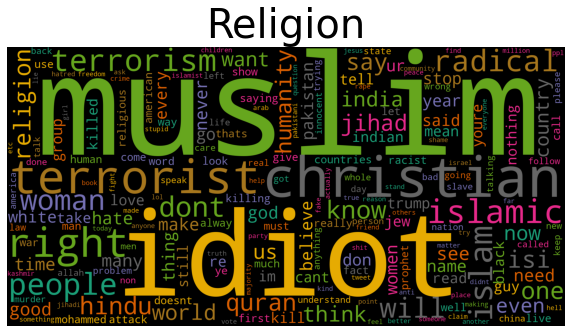

In [29]:
# Menampilkan visualisasi cyberbullying religion.

plt.figure(figsize=(10,8))
subset2 = df_prep_e[df_prep_e['cyberbullying_type']=='religion']
text_religion = subset2['Case Folding'].values
cloud2=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_religion))

plt.axis('off')
plt.title("Religion",fontsize=40)
plt.imshow(cloud2)

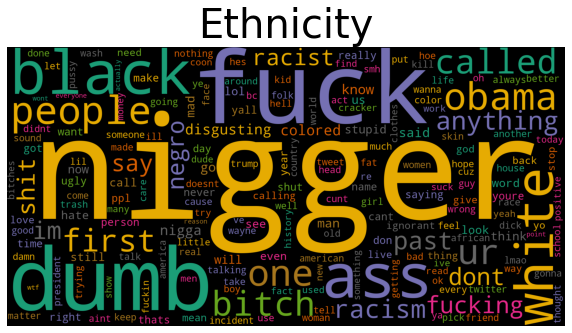

In [30]:
# Menampilkan visualisasi cyberbullying ethnicity.

plt.figure(figsize=(10,8))
subset3 = df_prep_e[df_prep_e['cyberbullying_type']=='ethnicity']
text_ethnicity = subset3['Case Folding'].values
cloud3=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_ethnicity))

plt.axis('off')
plt.title("Ethnicity",fontsize=40)
plt.imshow(cloud3)

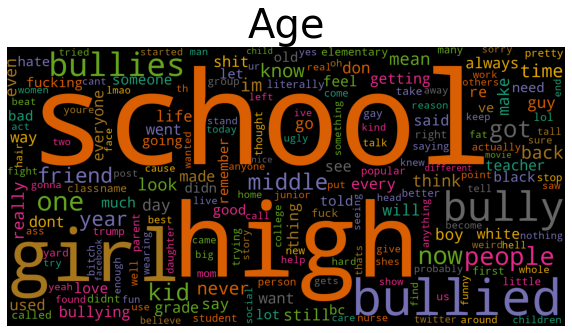

In [31]:
# Menampilkan visualisasi cyberbullying age.

plt.figure(figsize=(10,8))
subset4 = df_prep_e[df_prep_e['cyberbullying_type']=='age']
text_age = subset4['Case Folding'].values
cloud4=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_age))

plt.axis('off')
plt.title("Age",fontsize=40)
plt.imshow(cloud4)

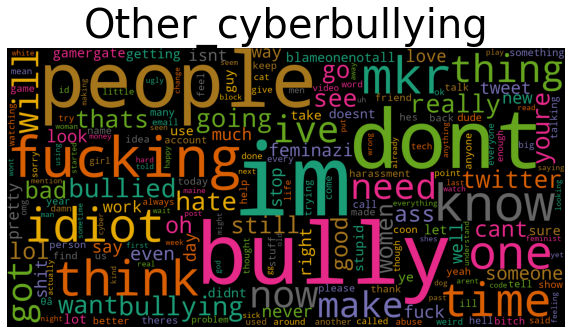

In [32]:
# Menampilkan visualisasi cyberbullying tipe lain.

plt.figure(figsize=(10,8))
subset5 = df_prep_e[df_prep_e['cyberbullying_type']=='other_cyberbullying']
text_other_cyberbullying = subset5['Case Folding'].values
cloud5=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_other_cyberbullying))

plt.axis('off')
plt.title("Other_cyberbullying",fontsize=40)
plt.imshow(cloud5)

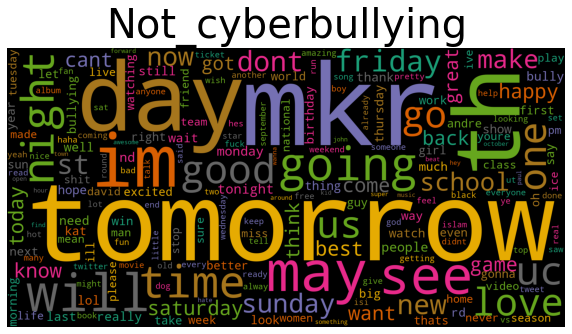

In [33]:
# Menampilkan visualisasi data bukan termasuk cyberbullying.

plt.figure(figsize=(10,8))
subset6 = df_prep_e[df_prep_e['cyberbullying_type']=='not_cyberbullying']
text_not_cyberbullying = subset6['Case Folding'].values
cloud6=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_not_cyberbullying))

plt.axis('off')
plt.title("Not_cyberbullying",fontsize=40)
plt.imshow(cloud6)

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [36]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
to_remove = ['•', '!', '"', '#', '”', '“', '$', '%', '&', "'", '–', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '…']
stop_words.update(to_remove)
print('Number of stopwords:', len(stop_words))

Number of stopwords: 226


In [37]:
# Membuat fungsi untuk menampilkan frekuensi semua label cyberbullying.

def freq(corpus,ngram_range,n=None):
    vector = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vector.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(words, sum_words[0, idx]) for words, idx in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [50]:
# Membuat fungsi untuk menampilkan frekuensi semua label cyberbullying.

def cyberbullying_type_data(cb_type, column_name='cyberbullying_type'):
    subset = df_prep_e[df_prep[column_name] == cb_type]
    text_data = subset['Case Folding'].values
    return text_data

In [51]:
# Membuat fungsi untuk menampilkan frekuensi semua label cyberbullying.

def most_used_words_phrases(cb_data, n=10):
    unigrams = freq(cb_data,(1,1),n)
    unigram_data = pd.DataFrame(unigrams, columns = ['Text' , 'count'])
    return unigram_data

In [52]:
# Membuat fungsi untuk menampilkan frekuensi semua label cyberbullying.

gender_data = most_used_words_phrases(cyberbullying_type_data('gender'), 20)
religion_data = most_used_words_phrases(cyberbullying_type_data('religion'), 20)
ethnicity_data = most_used_words_phrases(cyberbullying_type_data('ethnicity'), 20)
age_data = most_used_words_phrases(cyberbullying_type_data('age'), 20)
other_cb_data = most_used_words_phrases(cyberbullying_type_data('other_cyberbullying'), 20)
not_cb_data = most_used_words_phrases(cyberbullying_type_data('not_cyberbullying'), 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [53]:
print(cyberbullying_type_data('gender'))

['rape is realzvasiyana nema jokes about being drunk or being gay or being lesbianrape is not ones choice or wishthtz where the sensitivity is coming from'
 'you never saw any celebrity say anything like this for obama b maher incest rape joke s colbegay joke k griffin beheading joke'
 'i mean hes gay but he uses gendered slurs and makes rape jokes' ...
 'sucks to have the smile wiped off your own face huh kat she in a glass house should not throw stones mkr  mkr'
 'no he said women choose to be gay men dont he made rape jokes told a hg to go kill herself perpetrated gay stereotypes frankie  cody'
 'twitterfeminism cant convince three teen women to take up computer science meanwhile isis is soooo christian grey righ╟¬']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [54]:
# Membuat fungsi untuk menampilkan frekuensi semua label cyberbullying.

def create_word_bar(data, title):
    fig = px.bar(data, x = 'Text', y = 'count', color = 'Text',
                     labels={
                         'count': "Word Frequency"
                     },
                     title=title)
    fig.show()

In [55]:
# Membuat fungsi untuk menampilkan frekuensi semua label cyberbullying.

create_word_bar(gender_data, 'Gender')
create_word_bar(religion_data, 'Religion')
create_word_bar(ethnicity_data, 'Ethnicity')
create_word_bar(age_data, 'Age')
create_word_bar(other_cb_data, 'Other Cyberbullying')
create_word_bar(not_cb_data, 'Not Cyberbullying')

## Training - Evaluate Model

For the multiclass classification, we'll one-hot the target label before splitting them.

In [43]:
# Mengelompokkan kolom untuk X dan y sebelum dilakukan splitting data.

X = df_prep_e['Case Folding']
y = df_prep_e['cyberbullying_type']
y = pd.get_dummies(y).values

In [44]:
# Memisahkan antara data train, test dan valid. Menggunakan perbandingan nilai 80:20 dan random_state = 42.

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [45]:
# Mengkonstruksi data train dengan tensor.

print(X_train.shape)
X_tensor = tf.data.Dataset.from_tensor_slices(X_train)

(35084,)


In [46]:
# Mengatur tokenisasi menggunakan TextVectorization.

max_vocab_length = 30000 #untuk membatasi vocabnya sampai brp
max_length = 30 #maksimal kata dalam satu kalimat
shuffle = 5
batch_size = 32
text_vectorization = TextVectorization(max_tokens=max_vocab_length, #seberapa banyak token atau vocab
                                       standardize="lower_and_strip_punctuation", #auto menghilangkan tanda baca atau mengecilkan kata
                                       split="whitespace", #split berdasarkan spasi/jeda
                                       ngrams=None, #berapa kata yg ingin dijadikan vocab.
                                       output_mode='int',
                                       output_sequence_length=max_length)

In [ ]:
# Vektorisasi teks.

text_vectorization.adapt(X_tensor)

In [ ]:
# Membuat layer embedding.

embedding = Embedding(input_dim=max_vocab_length, #batas kata untuk input (30000 tadi seperti di atas)
                      output_dim=max_length, #angka boleh berapapun
                      input_length=max_length)

In [ ]:
# Membuat rancangan model untuk versi sequential API.

def get_basic_model(vectorization = text_vectorization):
    model = Sequential([
            vectorization,
            embedding,
            LSTM(128),
#           Dropout(0.2),
#           Dense(32, activation='relu'),
            Dense(6, activation='softmax')
])

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [ ]:
# Mengkonstruksi data train dengan tensor.

train_seq = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_seq = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_seq = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
# Mencoba berbagai macam batch yaitu 8, 16, 32, dan 64 pada data train, test dan valid.

batches_train32 = train_seq.shuffle(5).batch(32)
batches_valid32 = valid_seq.shuffle(5).batch(32)
batches_test32 = test_seq.shuffle(5).batch(32)

batches_train16 = train_seq.shuffle(5).batch(16)
batches_valid16 = valid_seq.shuffle(5).batch(16)
batches_test16 = test_seq.shuffle(5).batch(16)

batches_train8 = train_seq.shuffle(5).batch(8)
batches_valid8 = valid_seq.shuffle(5).batch(8)
batches_test8 = test_seq.shuffle(5).batch(8)

batches_train64 = train_seq.shuffle(5).batch(64)
batches_valid64 = valid_seq.shuffle(5).batch(64)
batches_test64 = test_seq.shuffle(5).batch(64)

In [ ]:
# Melakukan training pada model.

model8 = get_basic_model()

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history_seq_8 = model8.fit(batches_train8, epochs=100, validation_data=batches_valid8, callbacks = [es_callback, cp_callback])

In [ ]:
# Menampilkan grafik perbandingan loss dengan val_loss dan accuracy dengan val_accuracy.
# Hasil yang baik adalah keduanya semakin lama semakin turun.

hs8 = pd.DataFrame(history_seq_8.history)
hs8.plot()

# Terlihat bahwa masing-masing cenderung saling menjauhi pasangannya karena disebabkan overfitting pada model.

In [ ]:
# Mengevaluasi model kepada data test apakah berhasil atau tidak.

yp_seq = model8.predict(X_test)
y_pred = np.array(yp_seq).argmax(axis=1)
y_test_2 = np.argmax(y_test, axis=1)
report8L = pd.DataFrame(classification_report(y_test_2, y_pred, output_dict=True)).T
report8L.to_csv('8L.csv')
print(classification_report(y_test_2, y_pred))

# Menampilkan classification report hasil aplikasi model.
# Terlihat bahwa hasil accuracy pada F1-score menunjukkan angka yang cukup baik yaitu di 80%, sehingga model mampu diaplikasikan.
# Untuk meningkatkan performa model tentu perlu improvisasi lebih lanjut, tetapi dengan alasan keterbatasan waktu dan perolehan accuracy yang sudah cukup baik, maka model tersebut layak untuk digunakan.

In [ ]:
# Membuat data inference.

infer_text = ''' nice to meet you '''

In [ ]:
# Membuat fungsi untuk mengevaluasi hasil deteksi language pada data cyberbullying.

def predict_cb(text, model_used):
    abc = pd.DataFrame(columns=['tweet_text'])
    abc.loc[0] = text
    lang = load_model.predict(abc)
    if(lang!=3):
        print('Sorry, this is not in English')
    else:
        print('This tweet is in English')
        pred = model_used.predict(abc['Case Folding'])
        pred = np.argmax(pred)
        if(pred == 0):
            print("This tweet is detected as cyberbullying. It is cyberbullying related to age")
        elif(pred==1):
            print("This tweet is detected as cyberbullying. It is cyberbullying related to ethnicity")
        elif(pred==2):
            print("This tweet is detected as cyberbullying. It is cyberbullying related to gender")
        elif(pred==3):
            print("This tweet is safe!")
        elif(pred==4):
            print("This tweet is detected as cyberbullying with no specific category.")
        elif(pred==5):
            print("This tweet is detected as cyberbullying. It is cyberbullying related to religion")
        print(abc)

In [ ]:
# Mengevaluasi fungsi di atas pada data inference.

predict_cb(infer_text, model8)

In [ ]:
# Memuat semua bobot layer pada reconstruction_model.

reconstruction_model = get_basic_model()
reconstruction_model.load_weights(checkpoint_path)

In [ ]:
# Mengevaluasi fungsi di atas pada data inference menggunakan reconstruction_model.

predict_cb(infer_text, reconstruction_model)

In [ ]:
# Mengevaluasi model kepada data test menggunakan reconstruction_model.

yp_seq = reconstruction_model.predict(X_test)
y_pred = np.array(yp_seq).argmax(axis=1)
y_test_2 = np.argmax(y_test, axis=1)
report8L = pd.DataFrame(classification_report(y_test_2, y_pred, output_dict=True)).T
report8L.to_csv('recon8L.csv')
print(classification_report(y_test_2, y_pred))

In [ ]:
!zip -r modelcb.zip ./

General Conclusion :

1. The wordcloud visualization shows that there are indeed some words that were used frequently in some cyberbullying category, such as mentioning ethnicity (explicitly saying the word nigger, or mentioning Obama directly)

2. The result of the model LSTM perform better accuracy with F1-weighted average of 0.80. The model could be applicated.

3. For further improvement to get better number of accuracy and performance, need to get much time to running the model with improving the model.